In [1]:
from astropy.io import fits
import os
import matplotlib.pyplot as plt
import numpy as np
from scipy.optimize import curve_fit
from mpl_toolkits.mplot3d import Axes3D
%matplotlib inline
np.seterr(divide='ignore', invalid='ignore');
plt.rcParams.update({'figure.max_open_warning': 0})
import scipy.stats as stats
import astropy.units as u
from astropy.table import Table, Column, MaskedColumn, join
from tqdm import tqdm
from bisect import bisect_left
c = 2.998e10
k = 1.38e-16
h = 6.626e-27
plt.rcParams.update({'font.size': 22})
halpha = 6564.61
hbeta = 4862.68
hgamma = 4341.68
hdelta = 4102.89
plt.rcParams['figure.figsize'] = [15, 10]
from IPython.display import Audio, display
def allDone():
    display(Audio(filename='beep.mp3', autoplay=True))
from scipy.interpolate import interp1d,InterpolatedUnivariateSpline
import lmfit

def find_nearest(array, value):
    array = np.asarray(array)
    idx = (np.abs(array - value)).argmin()
    return idx
import emcee
import corner
import numdifftools
from scipy.ndimage import interpolation
from scipy.signal import medfilt
from scipy.interpolate import interp1d
from multiprocessing import Pool
import pickle
import h5py
import scipy

In [2]:
def get_spectrum(source_id):
    path = wdtable[wdtable['source_id'] == source_id][0]['specpath']
    try:
        f = fits.open(path)
        flux = f[1].data['flux']
        loglam = f[1].data['loglam']
        f.close()
        lam = 10**loglam
    except:
        print('Spectrum file missing...')
        return
    return lam,flux

In [3]:
wdtable = Table.read('filetable.fits')

In [5]:
def linear(wl,p1,p2):
    return p1 + p2*wl

def pv(l,lgamma,ggamma,centre,scale):
        
    Gamma = (ggamma**5 + 2.69269*ggamma**4 * lgamma + 2.42843*\
            ggamma**3 * lgamma**2 + 4.47163*lgamma**3 * ggamma**2 + \
            0.07842*ggamma * lgamma**4 + lgamma**5)**(1/5)
        
    neta = 1.36603*(lgamma/Gamma) - 0.47719*(lgamma/Gamma)**2 + 0.11116*(lgamma/Gamma)**3
        
    profile = 1 - scale * (neta*(1/(np.pi * lgamma)) * (lgamma**2) / ( (l-centre)**2 + lgamma**2 ) + (1-neta)*\
                           (1/np.sqrt(2*np.pi*ggamma**2)) * np.exp(-(l-centre)**2/(2*ggamma**2)))
    where = np.isnan(profile)
    profile[where] = 1
    profile = scipy.ndimage.filters.gaussian_filter1d(profile,5)
    return profile

def chisquare(residual):
    return np.sum(residual**2)

def fit_line(lam,flux,centroid):

    in1 = bisect_left(lam,centroid-130)
    in2 = bisect_left(lam,centroid+130)
    clam = lam[in1:in2]
    cflux = flux[in1:in2]

    cmask = (clam < centroid - 110)+(clam > centroid + 110)
#     plt.plot(clam,cflux)
#     plt.plot(clam[cmask],cflux[cmask])

    p,cov = curve_fit(linear,clam[cmask],cflux[cmask])

#     plt.plot(clam,linear(clam,p[0],p[1]))

    contcorr = -cflux/linear(clam,p[0],p[1]) + 1

    

    voigtfitter = lmfit.models.VoigtModel()
    params = voigtfitter.make_params()
    params['amplitude'].set(min = 0,max = 100,value = 10)
    params['center'].set(min = centroid-25,max= centroid+25,value = centroid)
    params['sigma'].set(min = 0,max=200,value=25)
    params['gamma'].set(value=25,min = 0,max=200,vary=True)

    result = voigtfitter.fit(contcorr,params,x = clam,nan_policy = 'omit',method='leastsq',\
                             fit_kws={'reduce_fcn':chisquare,'ftol':1e-25,'xtol':1e-25})
   
    plt.figure(figsize=(10,5))
    plt.plot(clam,-contcorr,'k')
    plt.plot(clam,-voigtfitter.eval(result.params,x=clam),'r')
    return result

 16%|█▌        | 16/100 [00:03<00:16,  5.05it/s]

Beta fit # 15 failed...


 28%|██▊       | 28/100 [00:05<00:14,  5.07it/s]

Spectrum file missing...


TypeError: 'NoneType' object is not subscriptable

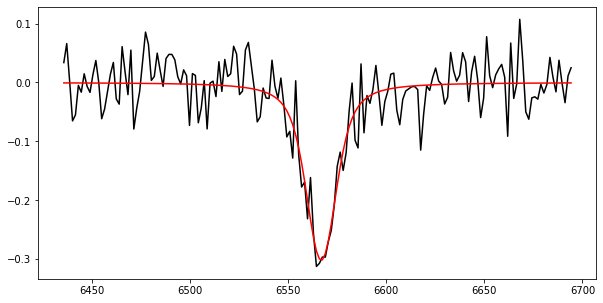

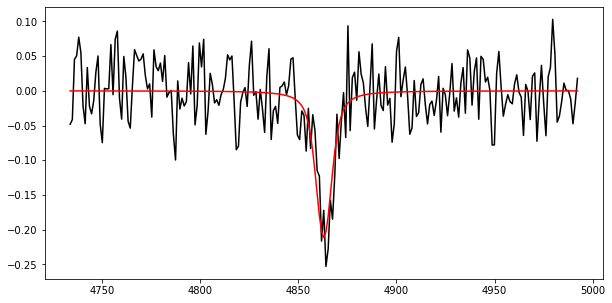

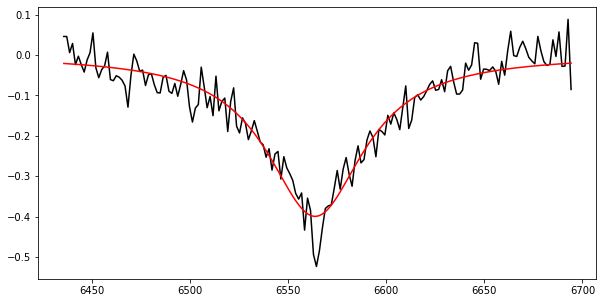

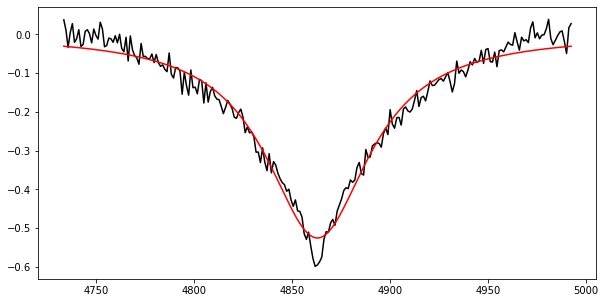

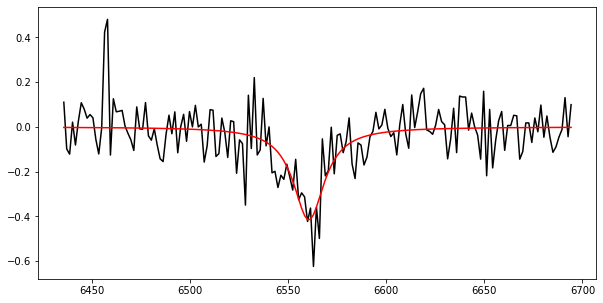

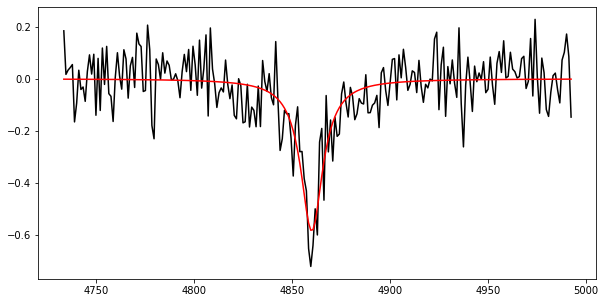

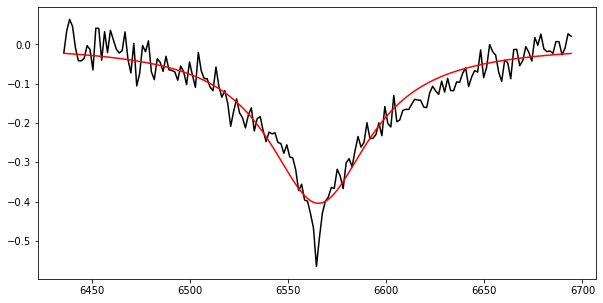

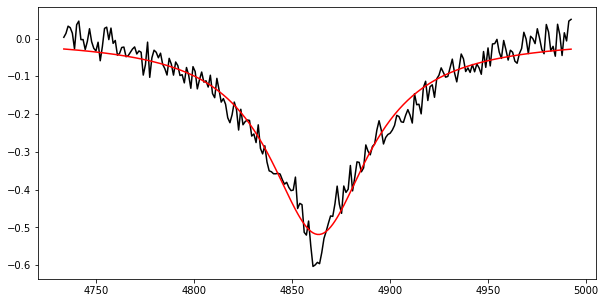

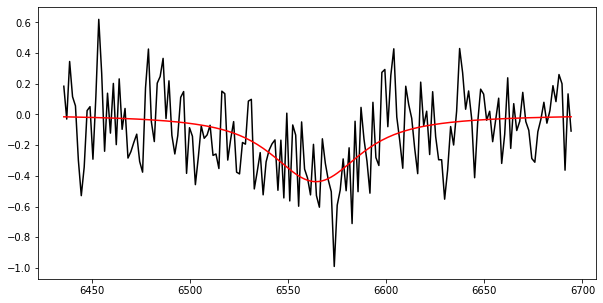

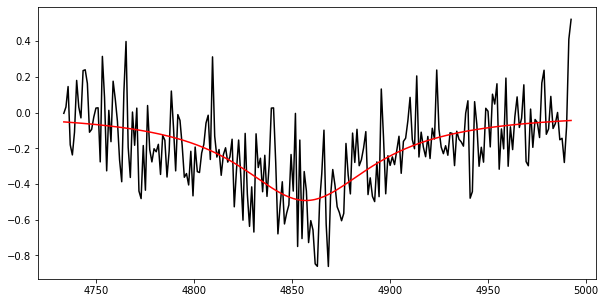

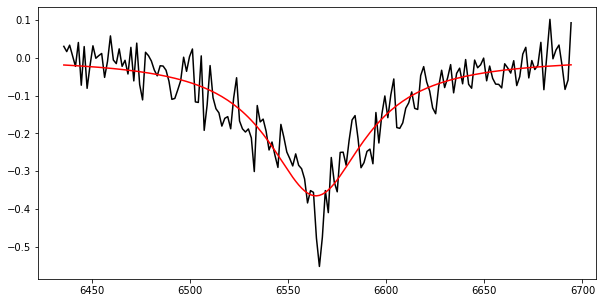

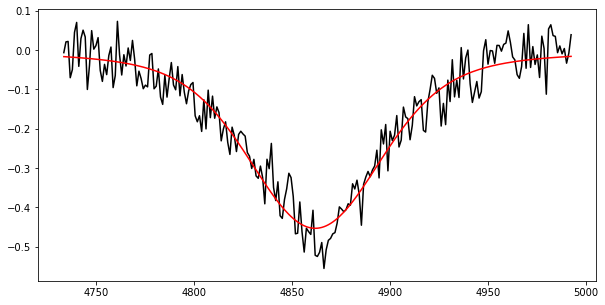

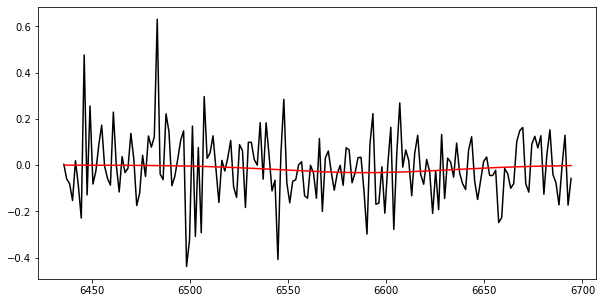

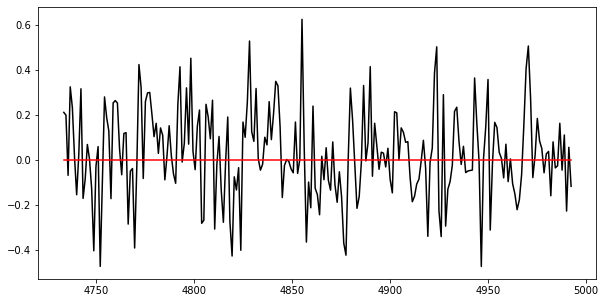

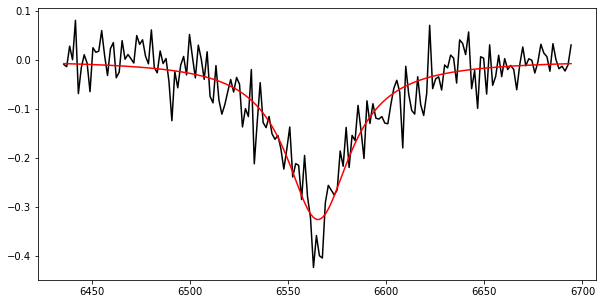

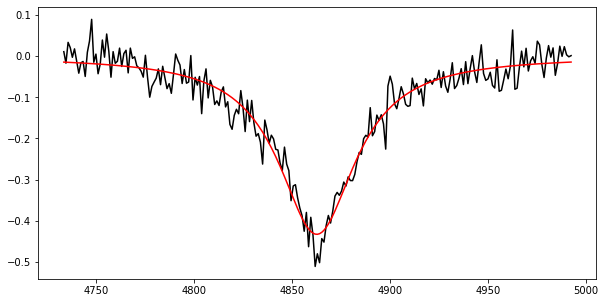

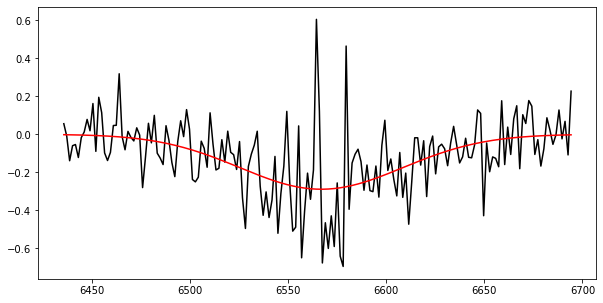

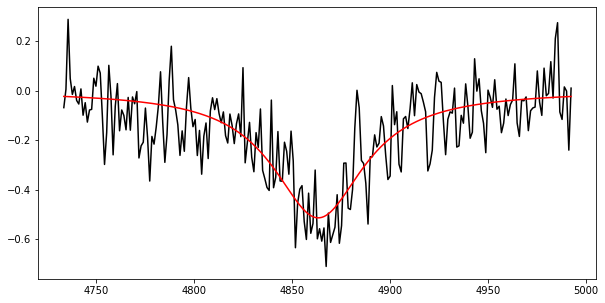

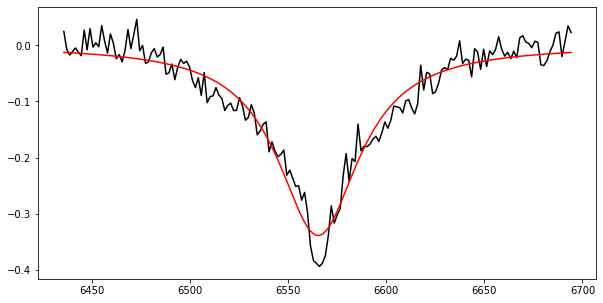

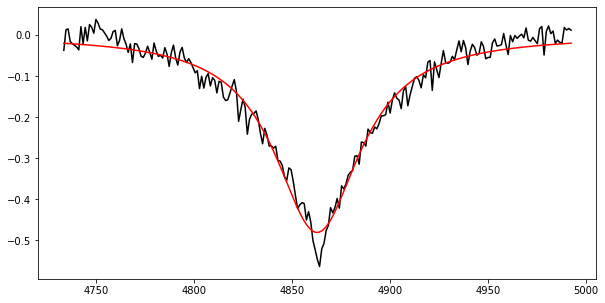

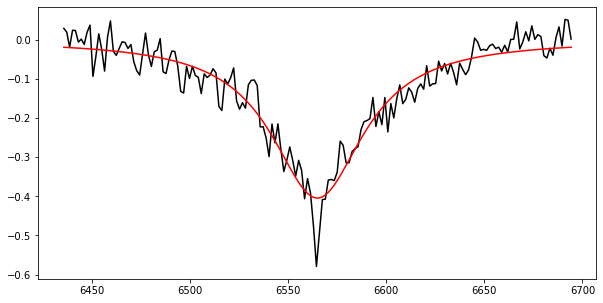

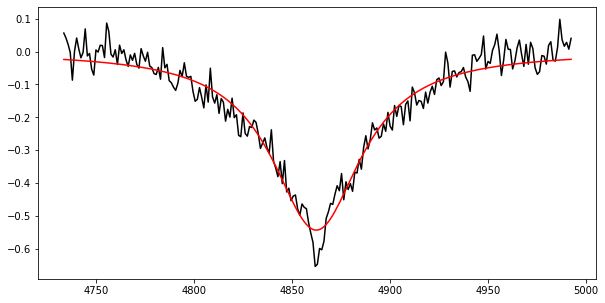

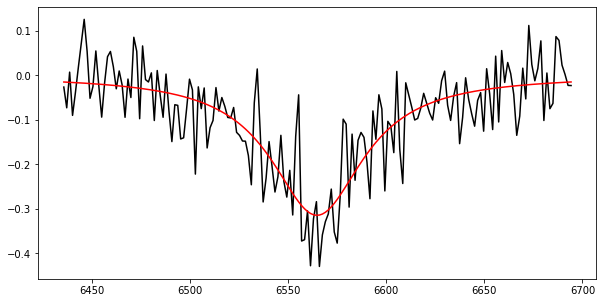

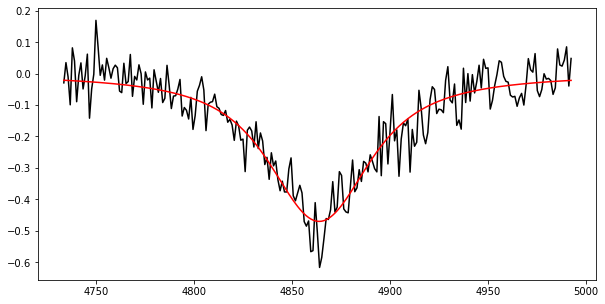

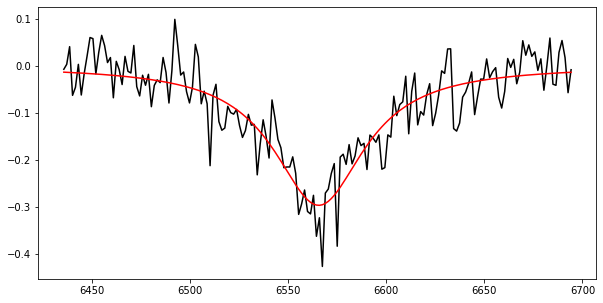

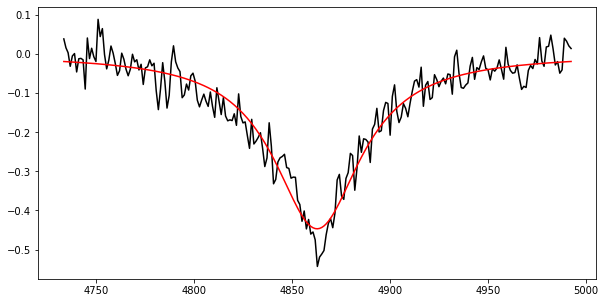

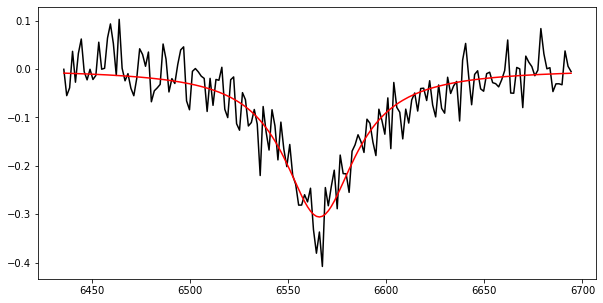

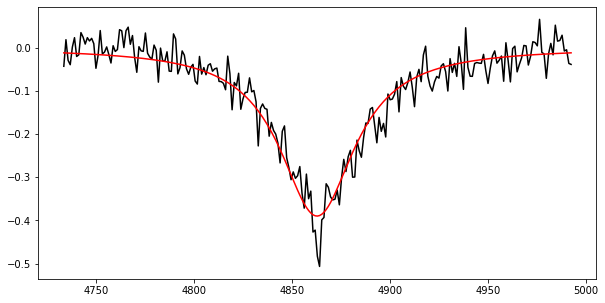

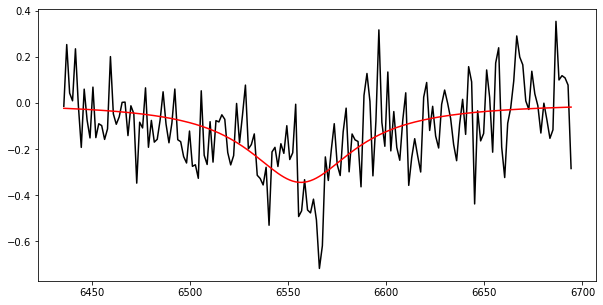

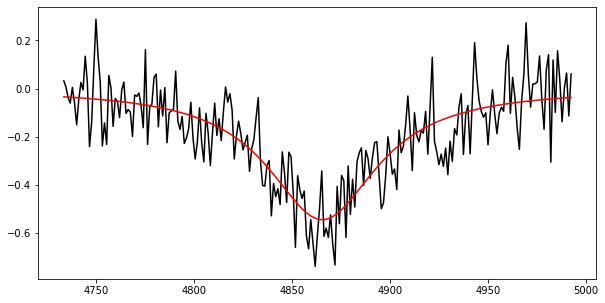

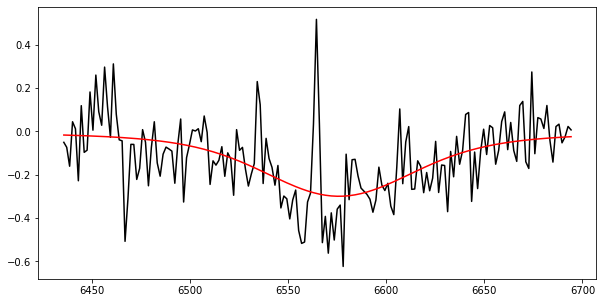

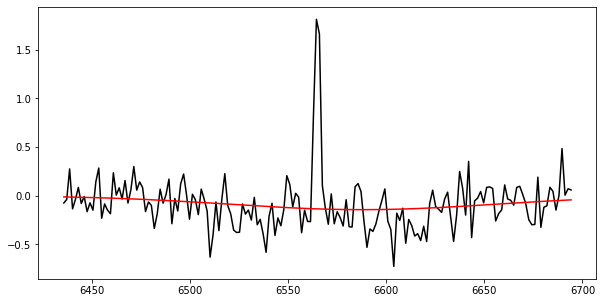

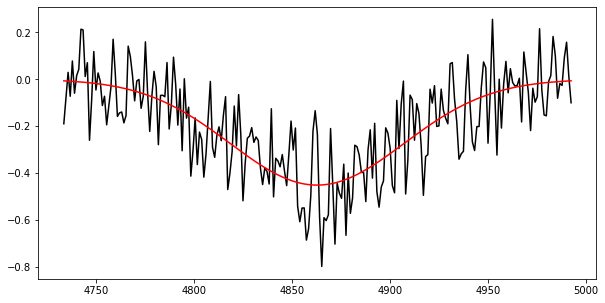

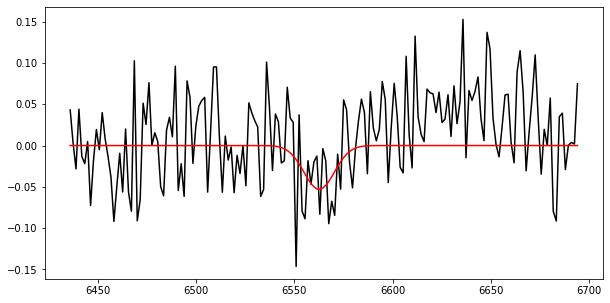

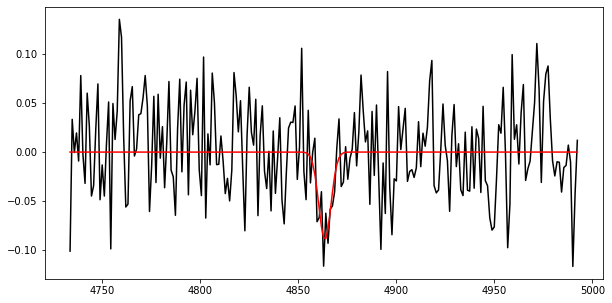

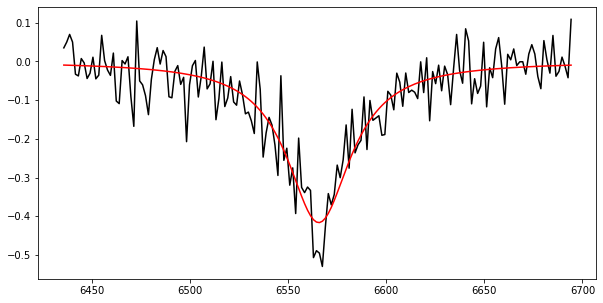

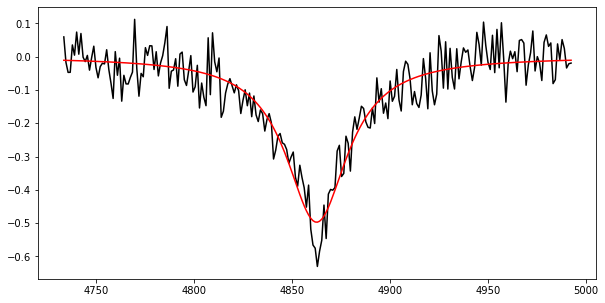

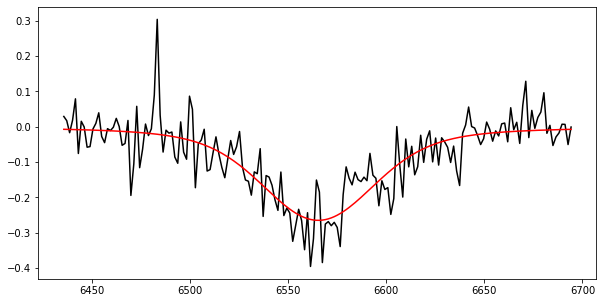

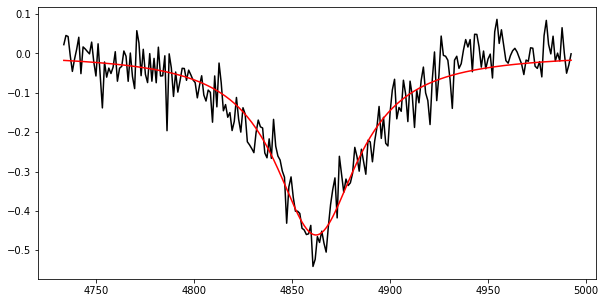

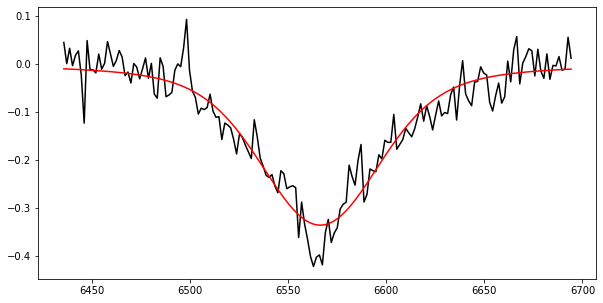

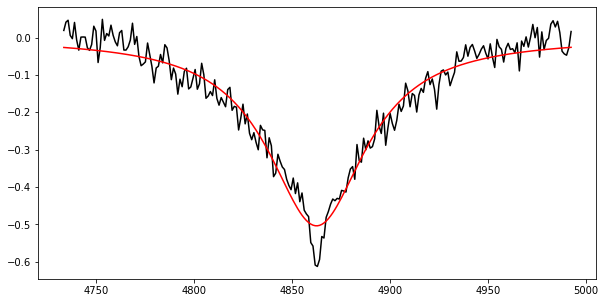

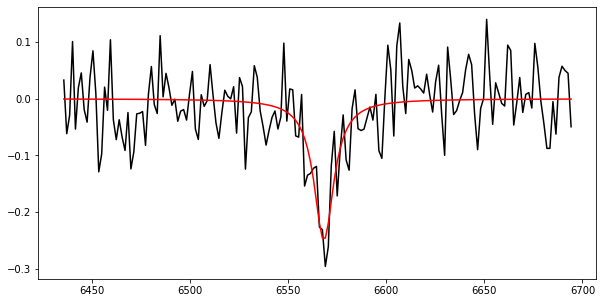

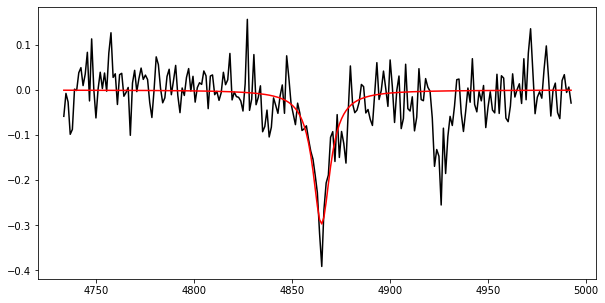

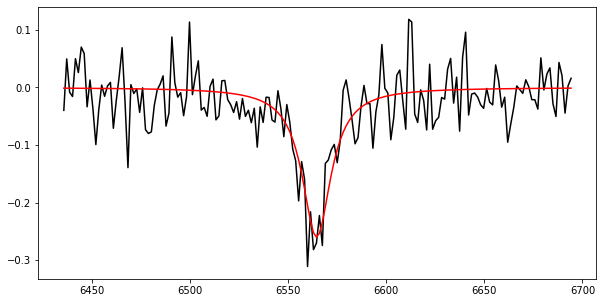

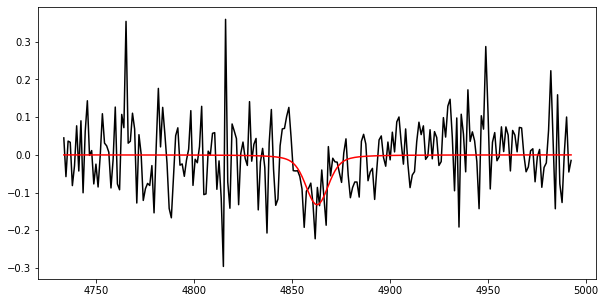

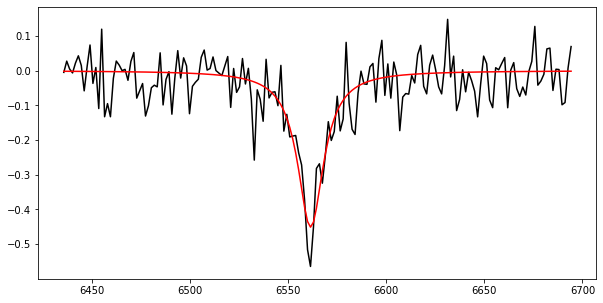

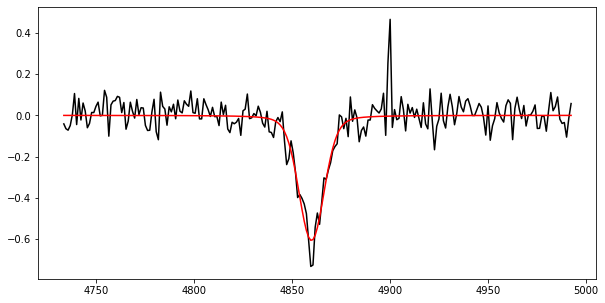

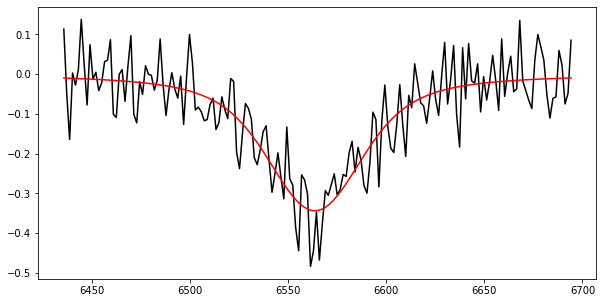

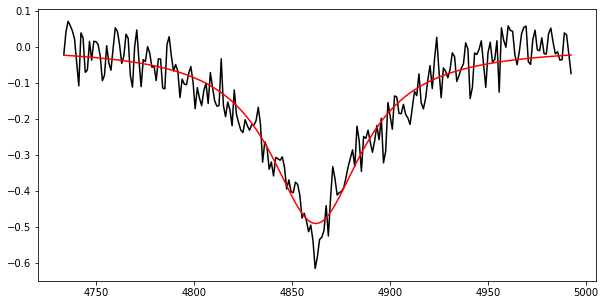

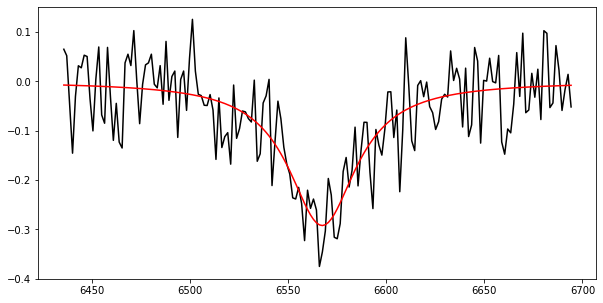

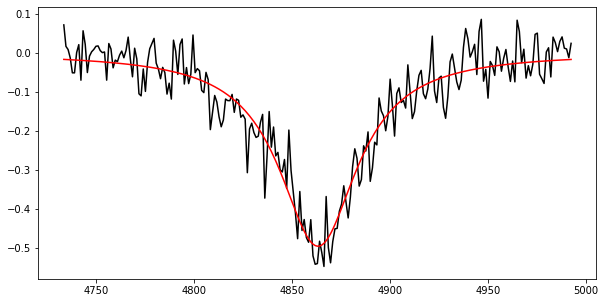

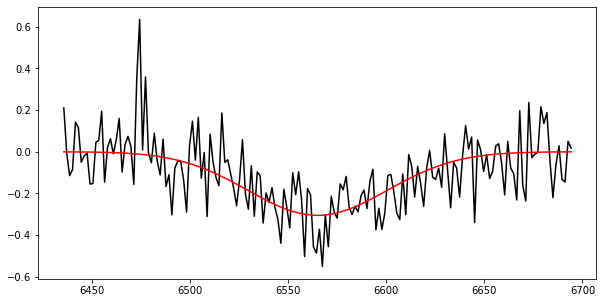

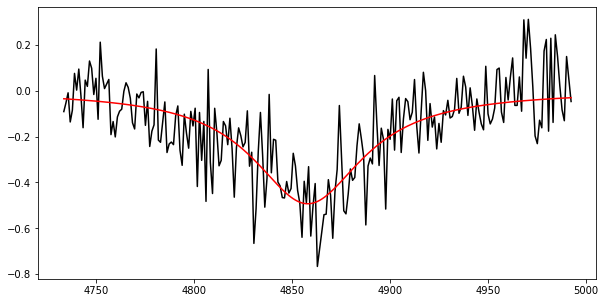

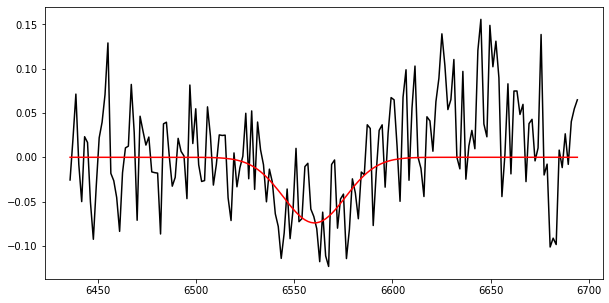

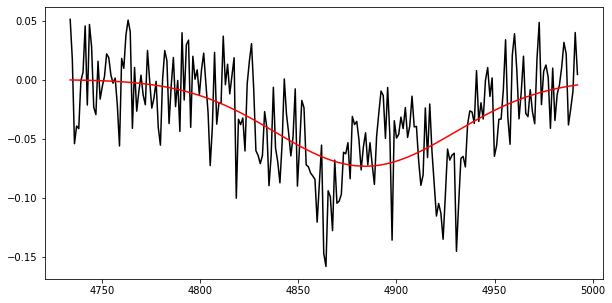

In [6]:
alphaparameters = np.zeros((len(wdtable),6))
betaparameters = np.zeros((len(wdtable),6))
for i in tqdm(range(len(wdtable[0:100]))):
    spec = get_spectrum(wdtable['source_id'][i])
    lam  = spec[0]
    flux = spec[1]
    try:
        alphafit = fit_line(lam,flux,halpha)
        alphaparameters[i,:] = np.array(alphafit.params)
        
    except:
        print('Alpha fit # %i failed...'%i)
    try:
        betafit = fit_line(lam,flux,hbeta)
        betaparameters[i,:] = np.array(betafit.params)
    except:
        print('Beta fit # %i failed...'%i)

In [6]:
betafit

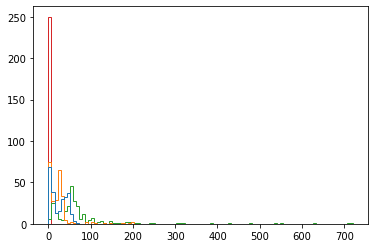

In [7]:
plt.hist(betaparameters[0:250,2:],histtype='step',bins=100);

In [3]:
import pickle

In [8]:
alphaparams = pickle.load(open('alphaparams.p','rb'))

In [9]:
betaparams = pickle.load(open('betaparams.p','rb'))

In [10]:
import seaborn as sns
import pandas as pd

In [11]:
alphaparams = pd.DataFrame(alphaparams)
betaparams = pd.DataFrame(betaparams)

In [12]:
alphaparams = alphaparams.rename(columns = {0:'sigma',1:'center',2:'amplitude',3:'gamma',4:'fwhm',5:'height'})
betaparams = betaparams.rename(columns = {0:'sigma',1:'center',2:'amplitude',3:'gamma',4:'fwhm',5:'height'})

In [13]:
wdtable['sigma_a'] = np.array(alphaparams['sigma'])
wdtable['center_a'] = np.array(alphaparams['center'])
wdtable['amplitude_a'] = np.array(alphaparams['amplitude'])
wdtable['gamma_a'] = np.array(alphaparams['gamma'])
wdtable['fwhm_a'] = np.array(alphaparams['fwhm'])
wdtable['height_a'] = np.array(alphaparams['height'])

In [25]:
wdtable['sigma_b'] = np.array(betaparams['sigma'])
wdtable['center_b'] = np.array(betaparams['center'])
wdtable['amplitude_b'] = np.array(betaparams['amplitude'])
wdtable['gamma_b'] = np.array(betaparams['gamma'])
wdtable['fwhm_b'] = np.array(betaparams['fwhm'])
wdtable['height_b'] = np.array(betaparams['height'])

In [27]:
DA = wdtable['spectral_class'] == 'DA'

(0, 100)

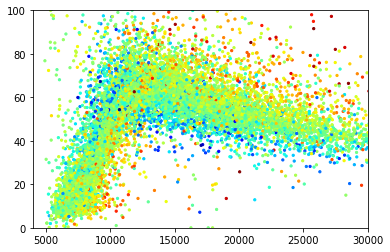

In [32]:
plt.scatter(wdtable['Teff'][DA],wdtable['fwhm_b'][DA],s = 5, c = wdtable['log_g'][DA], cmap = 'jet')
plt.xlim(4000,30000)
plt.ylim(0,100)

In [33]:
wdtable.write('linefits.fits')